# 전처리 + 학습

In [9]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 1. 감정 클래스 정의
primary_classes = ['긍정', '부정', '약올리기', '중립']
secondary_classes = [
    '긍정_웃김', '긍정_장난스러움',
    '부정_세모입', '부정_열받음',
    '중립_기본', '중립_몰입',
    '약올리기_단독' # 편의성을 위한 클래스 정의 -> 따로 if문으로 처리 안해도됨
]

# 2. 클래스 인덱스 매핑
primary_to_index = {cls: idx for idx, cls in enumerate(primary_classes)}
secondary_to_index = {cls: idx for idx, cls in enumerate(secondary_classes)}

# 3. 데이터 준비
img_size = 224
X = []
y_primary = []
y_secondary = []

base_path = './data'  # 감정 이미지 데이터 상위 경로

for primary in primary_classes:
    primary_path = os.path.join(base_path, primary)
    if not os.path.isdir(primary_path):
        continue

    for secondary in os.listdir(primary_path):
        secondary_path = os.path.join(primary_path, secondary)
        if not os.path.isdir(secondary_path):
            continue

        for fname in os.listdir(secondary_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(secondary_path, fname)
                img = cv2.imread(img_path)

                if img is None:
                    continue  # 손상된 이미지 예외 처리

                # 전처리: 크기 조정 및 정규화
                img = cv2.resize(img, (img_size, img_size))
                img = img.astype('float32') / 255.0

                # 이미지 및 라벨 저장
                X.append(img)
                y_primary.append(primary_to_index[primary])
                secondary_key = f"{primary}_{secondary}"
                y_secondary.append(secondary_to_index[secondary_key])

# 4. NumPy 배열 변환 + 원-핫 인코딩
X = np.array(X)
y_primary = to_categorical(y_primary, num_classes=len(primary_classes))
y_secondary = to_categorical(y_secondary, num_classes=len(secondary_classes))

# 5. 학습/검증 데이터 분할
X_train, X_val, y_train_primary, y_val_primary, y_train_secondary, y_val_secondary = train_test_split(
    X, y_primary, y_secondary, test_size=0.2, random_state=42)

# 모델구성

## EfficientNetB0 백본 + 이중 출력

In [10]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D

# EfficientNetB0 백본 로드 (ImageNet 사전학습 사용)
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)

# 1차 감정 (4 클래스) 출력
x1 = Dense(128, activation='relu')(x)
output_primary = Dense(4, activation='softmax', name='primary_output')(x1)

# 2차 감정 (7 클래스) 출력
x2 = Dense(128, activation='relu')(x)
output_secondary = Dense(7, activation='softmax', name='secondary_output')(x2)

# 모델 정의
model = Model(inputs=base_model.input, outputs=[output_primary, output_secondary])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,378,926 (16.70 MB)

 Trainable params: 4,336,903 (16.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [18]:
# 모델 컴파일
model.compile(
    optimizer='adam',
    loss={
        'primary_output': 'categorical_crossentropy',
        'secondary_output': 'categorical_crossentropy'
    },
    loss_weights={'primary_output': 1.0, 'secondary_output': 1.0},
    metrics={
        'primary_output': 'accuracy',
        'secondary_output': 'accuracy'
    }
)

In [19]:
# 진행도 확인 콜백
from tensorflow.keras.callbacks import Callback
from tqdm import tqdm

class TQDMProgressBar(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epochs = self.params['epochs']
        self.pbar = tqdm(total=self.params['steps'], desc=f"Epoch {epoch+1}/{self.epochs}", unit='step')

    def on_batch_end(self, batch, logs=None):
        self.pbar.update(1)

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.close()

In [25]:
# 모델 학습
history = model.fit(
    X_train,
    {
        'primary_output': y_train_primary,
        'secondary_output': y_train_secondary
    },
    validation_data=(
        X_val,
        {
            'primary_output': y_val_primary,
            'secondary_output': y_val_secondary
        }
    ),
    epochs=20,
    batch_size=32,
    callbacks=[TQDMProgressBar()]  # 진행률 표시
)

Epoch 1/20:   0%|                                                                              | 0/4 [00:00<?, ?step/s]

Epoch 1/20


Epoch 1/20:  25%|█████████████████▌                                                    | 1/4 [00:29<01:29, 29.97s/step]

1/4 ━━━━━━━━━━━━━━━━━━━━ 1:29 30s/step - loss: 0.8720 - primary_output_accuracy: 0.9375 - primary_output_loss: 0.4895 - secondary_output_accuracy: 0.9375 - secondary_output_loss: 0.3825

Epoch 1/20:  50%|███████████████████████████████████                                   | 2/4 [00:47<00:45, 22.78s/step]

2/4 ━━━━━━━━━━━━━━━━━━━━ 35s 18s/step - loss: 0.6556 - primary_output_accuracy: 0.9531 - primary_output_loss: 0.3673 - secondary_output_accuracy: 0.9531 - secondary_output_loss: 0.2883 

Epoch 1/20:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:02<00:19, 19.09s/step]

3/4 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - loss: 0.5365 - primary_output_accuracy: 0.9618 - primary_output_loss: 0.2996 - secondary_output_accuracy: 0.9618 - secondary_output_loss: 0.2368

Epoch 1/20: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [01:11<00:00, 15.06s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 0.4960 - primary_output_accuracy: 0.9622 - primary_output_loss: 0.2901 - secondary_output_accuracy: 0.9622 - secondary_output_loss: 0.2268 

Epoch 1/20: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [01:14<00:00, 18.68s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 75s 15s/step - loss: 0.4717 - primary_output_accuracy: 0.9624 - primary_output_loss: 0.2844 - secondary_output_accuracy: 0.9624 - secondary_output_loss: 0.2207 - val_loss: 7.4522 - val_primary_output_accuracy: 0.1786 - val_primary_output_loss: 3.7738 - val_secondary_output_accuracy: 0.1429 - val_secondary_output_loss: 3.6785



Epoch 2/20:   0%|                                                                              | 0/4 [00:00<?, ?step/s]

Epoch 2/20


Epoch 2/20:  25%|█████████████████▌                                                    | 1/4 [00:10<00:31, 10.66s/step]

1/4 ━━━━━━━━━━━━━━━━━━━━ 31s 11s/step - loss: 0.0594 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0375 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0219

Epoch 2/20:  50%|███████████████████████████████████                                   | 2/4 [00:20<00:20, 10.37s/step]

2/4 ━━━━━━━━━━━━━━━━━━━━ 20s 10s/step - loss: 0.0574 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0298 - secondary_output_accuracy: 0.9922 - secondary_output_loss: 0.0276

Epoch 2/20:  75%|████████████████████████████████████████████████████▌                 | 3/4 [00:29<00:09,  9.41s/step]

3/4 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0534 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0266 - secondary_output_accuracy: 0.9913 - secondary_output_loss: 0.0268  

Epoch 2/20: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:33<00:00,  7.32s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0532 - primary_output_accuracy: 0.9977 - primary_output_loss: 0.0286 - secondary_output_accuracy: 0.9912 - secondary_output_loss: 0.0267

Epoch 2/20: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:35<00:00,  8.81s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 8s/step - loss: 0.0531 - primary_output_accuracy: 0.9963 - primary_output_loss: 0.0297 - secondary_output_accuracy: 0.9911 - secondary_output_loss: 0.0266 - val_loss: 6.8786 - val_primary_output_accuracy: 0.1786 - val_primary_output_loss: 3.2977 - val_secondary_output_accuracy: 0.1429 - val_secondary_output_loss: 3.5809



Epoch 3/20:   0%|                                                                              | 0/4 [00:00<?, ?step/s]

Epoch 3/20


Epoch 3/20:  25%|█████████████████▌                                                    | 1/4 [00:08<00:26,  8.74s/step]

1/4 ━━━━━━━━━━━━━━━━━━━━ 26s 9s/step - loss: 0.0653 - primary_output_accuracy: 0.9688 - primary_output_loss: 0.0299 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0355

Epoch 3/20:  50%|███████████████████████████████████                                   | 2/4 [00:17<00:17,  8.53s/step]

2/4 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step - loss: 0.0684 - primary_output_accuracy: 0.9688 - primary_output_loss: 0.0347 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0338

Epoch 3/20:  75%|████████████████████████████████████████████████████▌                 | 3/4 [00:25<00:08,  8.62s/step]

3/4 ━━━━━━━━━━━━━━━━━━━━ 8s 9s/step - loss: 0.0808 - primary_output_accuracy: 0.9653 - primary_output_loss: 0.0495 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0313 

Epoch 3/20: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:29<00:00,  6.59s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 0.1036 - primary_output_accuracy: 0.9602 - primary_output_loss: 0.0744 - secondary_output_accuracy: 0.9977 - secondary_output_loss: 0.0474

Epoch 3/20: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:31<00:00,  7.82s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step - loss: 0.1172 - primary_output_accuracy: 0.9571 - primary_output_loss: 0.0892 - secondary_output_accuracy: 0.9963 - secondary_output_loss: 0.0571 - val_loss: 6.9045 - val_primary_output_accuracy: 0.1786 - val_primary_output_loss: 3.2211 - val_secondary_output_accuracy: 0.1429 - val_secondary_output_loss: 3.6835



Epoch 4/20:   0%|                                                                              | 0/4 [00:00<?, ?step/s]

Epoch 4/20


Epoch 4/20:  25%|█████████████████▌                                                    | 1/4 [00:08<00:26,  8.93s/step]

1/4 ━━━━━━━━━━━━━━━━━━━━ 26s 9s/step - loss: 0.1031 - primary_output_accuracy: 0.9688 - primary_output_loss: 0.0775 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0255

Epoch 4/20:  50%|███████████████████████████████████                                   | 2/4 [00:17<00:17,  8.57s/step]

2/4 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step - loss: 0.1300 - primary_output_accuracy: 0.9531 - primary_output_loss: 0.0954 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0346

Epoch 4/20:  75%|████████████████████████████████████████████████████▌                 | 3/4 [00:25<00:08,  8.54s/step]

3/4 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.1292 - primary_output_accuracy: 0.9549 - primary_output_loss: 0.0924 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0367 

Epoch 4/20: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:29<00:00,  6.56s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 0.1490 - primary_output_accuracy: 0.9524 - primary_output_loss: 0.1086 - secondary_output_accuracy: 0.9954 - secondary_output_loss: 0.0626

Epoch 4/20: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:30<00:00,  7.73s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 7s/step - loss: 0.1609 - primary_output_accuracy: 0.9509 - primary_output_loss: 0.1183 - secondary_output_accuracy: 0.9927 - secondary_output_loss: 0.0782 - val_loss: 7.2951 - val_primary_output_accuracy: 0.1786 - val_primary_output_loss: 3.4369 - val_secondary_output_accuracy: 0.1429 - val_secondary_output_loss: 3.8582



Epoch 5/20:   0%|                                                                              | 0/4 [00:00<?, ?step/s]

Epoch 5/20


Epoch 5/20:  25%|█████████████████▌                                                    | 1/4 [00:08<00:26,  8.93s/step]

1/4 ━━━━━━━━━━━━━━━━━━━━ 26s 9s/step - loss: 0.0680 - primary_output_accuracy: 0.9688 - primary_output_loss: 0.0513 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0167

Epoch 5/20:  50%|███████████████████████████████████                                   | 2/4 [00:17<00:17,  8.60s/step]

2/4 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step - loss: 0.0605 - primary_output_accuracy: 0.9766 - primary_output_loss: 0.0412 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0193

Epoch 5/20:  75%|████████████████████████████████████████████████████▌                 | 3/4 [00:24<00:08,  8.18s/step]

3/4 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.1020 - primary_output_accuracy: 0.9774 - primary_output_loss: 0.0409 - secondary_output_accuracy: 0.9792 - secondary_output_loss: 0.0610 

Epoch 5/20: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:28<00:00,  6.16s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.1218 - primary_output_accuracy: 0.9785 - primary_output_loss: 0.0439 - secondary_output_accuracy: 0.9706 - secondary_output_loss: 0.0769

Epoch 5/20: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:29<00:00,  7.37s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 7s/step - loss: 0.1337 - primary_output_accuracy: 0.9791 - primary_output_loss: 0.0456 - secondary_output_accuracy: 0.9655 - secondary_output_loss: 0.0865 - val_loss: 7.2561 - val_primary_output_accuracy: 0.1786 - val_primary_output_loss: 3.5892 - val_secondary_output_accuracy: 0.1429 - val_secondary_output_loss: 3.6669



Epoch 6/20:   0%|                                                                              | 0/4 [00:00<?, ?step/s]

Epoch 6/20


Epoch 6/20:  25%|█████████████████▌                                                    | 1/4 [00:07<00:22,  7.41s/step]

1/4 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step - loss: 0.1612 - primary_output_accuracy: 0.9688 - primary_output_loss: 0.0966 - secondary_output_accuracy: 0.9688 - secondary_output_loss: 0.0645

Epoch 6/20:  50%|███████████████████████████████████                                   | 2/4 [00:14<00:14,  7.11s/step]

2/4 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - loss: 0.1466 - primary_output_accuracy: 0.9688 - primary_output_loss: 0.0895 - secondary_output_accuracy: 0.9766 - secondary_output_loss: 0.0571

Epoch 6/20:  75%|████████████████████████████████████████████████████▌                 | 3/4 [00:21<00:06,  6.97s/step]

3/4 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - loss: 0.1789 - primary_output_accuracy: 0.9549 - primary_output_loss: 0.1140 - secondary_output_accuracy: 0.9740 - secondary_output_loss: 0.0649 

Epoch 6/20: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:24<00:00,  5.40s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.2852 - primary_output_accuracy: 0.9409 - primary_output_loss: 0.2282 - secondary_output_accuracy: 0.9667 - secondary_output_loss: 0.1559

Epoch 6/20: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.35s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - loss: 0.3490 - primary_output_accuracy: 0.9325 - primary_output_loss: 0.2967 - secondary_output_accuracy: 0.9624 - secondary_output_loss: 0.2104 - val_loss: 6.2513 - val_primary_output_accuracy: 0.1786 - val_primary_output_loss: 3.2058 - val_secondary_output_accuracy: 0.1429 - val_secondary_output_loss: 3.0456



Epoch 7/20:   0%|                                                                              | 0/4 [00:00<?, ?step/s]

Epoch 7/20


Epoch 7/20:  25%|█████████████████▌                                                    | 1/4 [00:06<00:20,  6.90s/step]

1/4 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - loss: 0.1086 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0773 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0314

Epoch 7/20:  50%|███████████████████████████████████                                   | 2/4 [00:13<00:13,  6.93s/step]

2/4 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - loss: 0.1625 - primary_output_accuracy: 0.9922 - primary_output_loss: 0.0821 - secondary_output_accuracy: 0.9844 - secondary_output_loss: 0.0804

Epoch 7/20:  75%|████████████████████████████████████████████████████▌                 | 3/4 [00:20<00:06,  6.76s/step]

3/4 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - loss: 0.2122 - primary_output_accuracy: 0.9913 - primary_output_loss: 0.0813 - secondary_output_accuracy: 0.9792 - secondary_output_loss: 0.1309 

Epoch 7/20: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.27s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.2580 - primary_output_accuracy: 0.9843 - primary_output_loss: 0.1092 - secondary_output_accuracy: 0.9706 - secondary_output_loss: 0.1716

Epoch 7/20: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:24<00:00,  6.18s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - loss: 0.2854 - primary_output_accuracy: 0.9801 - primary_output_loss: 0.1259 - secondary_output_accuracy: 0.9655 - secondary_output_loss: 0.1960 - val_loss: 6.0236 - val_primary_output_accuracy: 0.1786 - val_primary_output_loss: 2.9082 - val_secondary_output_accuracy: 0.1429 - val_secondary_output_loss: 3.1155



Epoch 8/20:   0%|                                                                              | 0/4 [00:00<?, ?step/s]

Epoch 8/20


Epoch 8/20:  25%|█████████████████▌                                                    | 1/4 [00:06<00:19,  6.65s/step]

1/4 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step - loss: 0.3861 - primary_output_accuracy: 0.9688 - primary_output_loss: 0.1015 - secondary_output_accuracy: 0.9375 - secondary_output_loss: 0.2846

Epoch 8/20:  50%|███████████████████████████████████                                   | 2/4 [00:13<00:13,  6.82s/step]

2/4 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - loss: 0.3929 - primary_output_accuracy: 0.9609 - primary_output_loss: 0.1294 - secondary_output_accuracy: 0.9375 - secondary_output_loss: 0.2635

Epoch 8/20:  75%|████████████████████████████████████████████████████▌                 | 3/4 [00:20<00:06,  6.84s/step]

3/4 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - loss: 0.3638 - primary_output_accuracy: 0.9635 - primary_output_loss: 0.1255 - secondary_output_accuracy: 0.9444 - secondary_output_loss: 0.2383 

Epoch 8/20: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.33s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.3408 - primary_output_accuracy: 0.9658 - primary_output_loss: 0.1169 - secondary_output_accuracy: 0.9492 - secondary_output_loss: 0.2148

Epoch 8/20: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:24<00:00,  6.24s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - loss: 0.3271 - primary_output_accuracy: 0.9671 - primary_output_loss: 0.1118 - secondary_output_accuracy: 0.9520 - secondary_output_loss: 0.2007 - val_loss: 5.9316 - val_primary_output_accuracy: 0.3929 - val_primary_output_loss: 2.5814 - val_secondary_output_accuracy: 0.2143 - val_secondary_output_loss: 3.3501



Epoch 9/20:   0%|                                                                              | 0/4 [00:00<?, ?step/s]

Epoch 9/20


Epoch 9/20:  25%|█████████████████▌                                                    | 1/4 [00:06<00:20,  6.90s/step]

1/4 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - loss: 0.1522 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0416 - secondary_output_accuracy: 0.9688 - secondary_output_loss: 0.1105

Epoch 9/20:  50%|███████████████████████████████████                                   | 2/4 [00:13<00:13,  6.73s/step]

2/4 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - loss: 0.1322 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0433 - secondary_output_accuracy: 0.9766 - secondary_output_loss: 0.0889

Epoch 9/20:  75%|████████████████████████████████████████████████████▌                 | 3/4 [00:20<00:06,  6.69s/step]

3/4 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - loss: 0.1880 - primary_output_accuracy: 0.9896 - primary_output_loss: 0.0780 - secondary_output_accuracy: 0.9740 - secondary_output_loss: 0.1100 

Epoch 9/20: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.20s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.2366 - primary_output_accuracy: 0.9807 - primary_output_loss: 0.1198 - secondary_output_accuracy: 0.9713 - secondary_output_loss: 0.1395

Epoch 9/20: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:24<00:00,  6.05s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - loss: 0.2657 - primary_output_accuracy: 0.9754 - primary_output_loss: 0.1448 - secondary_output_accuracy: 0.9697 - secondary_output_loss: 0.1572 - val_loss: 8.0201 - val_primary_output_accuracy: 0.3929 - val_primary_output_loss: 3.3384 - val_secondary_output_accuracy: 0.2143 - val_secondary_output_loss: 4.6816



Epoch 10/20:   0%|                                                                             | 0/4 [00:00<?, ?step/s]

Epoch 10/20


Epoch 10/20:  25%|█████████████████▎                                                   | 1/4 [00:06<00:18,  6.22s/step]

1/4 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 0.0352 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0171 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0181

Epoch 10/20:  50%|██████████████████████████████████▌                                  | 2/4 [00:13<00:13,  6.56s/step]

2/4 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - loss: 0.0499 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0229 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0270

Epoch 10/20:  75%|███████████████████████████████████████████████████▊                 | 3/4 [00:19<00:06,  6.52s/step]

3/4 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - loss: 0.0528 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0237 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0291 

Epoch 10/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.06s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0598 - primary_output_accuracy: 0.9977 - primary_output_loss: 0.0346 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0312

Epoch 10/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.85s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - loss: 0.0640 - primary_output_accuracy: 0.9963 - primary_output_loss: 0.0411 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0324 - val_loss: 9.3176 - val_primary_output_accuracy: 0.3929 - val_primary_output_loss: 3.7544 - val_secondary_output_accuracy: 0.2143 - val_secondary_output_loss: 5.5632



Epoch 11/20:   0%|                                                                             | 0/4 [00:00<?, ?step/s]

Epoch 11/20


Epoch 11/20:  25%|█████████████████▎                                                   | 1/4 [00:06<00:20,  6.77s/step]

1/4 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - loss: 0.0831 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0339 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0492

Epoch 11/20:  50%|██████████████████████████████████▌                                  | 2/4 [00:13<00:13,  6.58s/step]

2/4 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 0.0975 - primary_output_accuracy: 0.9922 - primary_output_loss: 0.0440 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0535

Epoch 11/20:  75%|███████████████████████████████████████████████████▊                 | 3/4 [00:20<00:06,  6.72s/step]

3/4 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - loss: 0.1203 - primary_output_accuracy: 0.9844 - primary_output_loss: 0.0592 - secondary_output_accuracy: 0.9965 - secondary_output_loss: 0.0611 

Epoch 11/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.23s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.1489 - primary_output_accuracy: 0.9791 - primary_output_loss: 0.0847 - secondary_output_accuracy: 0.9905 - secondary_output_loss: 0.0831

Epoch 11/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:24<00:00,  6.08s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - loss: 0.1661 - primary_output_accuracy: 0.9759 - primary_output_loss: 0.1000 - secondary_output_accuracy: 0.9869 - secondary_output_loss: 0.0964 - val_loss: 10.0259 - val_primary_output_accuracy: 0.3929 - val_primary_output_loss: 3.9667 - val_secondary_output_accuracy: 0.2143 - val_secondary_output_loss: 6.0592



Epoch 12/20:   0%|                                                                             | 0/4 [00:00<?, ?step/s]

Epoch 12/20


Epoch 12/20:  25%|█████████████████▎                                                   | 1/4 [00:07<00:21,  7.06s/step]

1/4 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - loss: 0.2135 - primary_output_accuracy: 0.9688 - primary_output_loss: 0.1264 - secondary_output_accuracy: 0.9688 - secondary_output_loss: 0.0872

Epoch 12/20:  50%|██████████████████████████████████▌                                  | 2/4 [00:14<00:14,  7.06s/step]

2/4 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - loss: 0.2452 - primary_output_accuracy: 0.9688 - primary_output_loss: 0.1344 - secondary_output_accuracy: 0.9609 - secondary_output_loss: 0.1108

Epoch 12/20:  75%|███████████████████████████████████████████████████▊                 | 3/4 [00:20<00:06,  6.85s/step]

3/4 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - loss: 0.2803 - primary_output_accuracy: 0.9653 - primary_output_loss: 0.1503 - secondary_output_accuracy: 0.9497 - secondary_output_loss: 0.1300 

Epoch 12/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.35s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.2896 - primary_output_accuracy: 0.9648 - primary_output_loss: 0.1489 - secondary_output_accuracy: 0.9462 - secondary_output_loss: 0.1318

Epoch 12/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:24<00:00,  6.25s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - loss: 0.2953 - primary_output_accuracy: 0.9645 - primary_output_loss: 0.1481 - secondary_output_accuracy: 0.9441 - secondary_output_loss: 0.1328 - val_loss: 10.0078 - val_primary_output_accuracy: 0.3929 - val_primary_output_loss: 3.9058 - val_secondary_output_accuracy: 0.2143 - val_secondary_output_loss: 6.1019



Epoch 13/20:   0%|                                                                             | 0/4 [00:00<?, ?step/s]

Epoch 13/20


Epoch 13/20:  25%|█████████████████▎                                                   | 1/4 [00:06<00:19,  6.66s/step]

1/4 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - loss: 0.1400 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0288 - secondary_output_accuracy: 0.9688 - secondary_output_loss: 0.1111

Epoch 13/20:  50%|██████████████████████████████████▌                                  | 2/4 [00:13<00:13,  6.90s/step]

2/4 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - loss: 0.1567 - primary_output_accuracy: 0.9922 - primary_output_loss: 0.0553 - secondary_output_accuracy: 0.9766 - secondary_output_loss: 0.1014

Epoch 13/20:  75%|███████████████████████████████████████████████████▊                 | 3/4 [00:20<00:06,  6.93s/step]

3/4 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.1684 - primary_output_accuracy: 0.9878 - primary_output_loss: 0.0653 - secondary_output_accuracy: 0.9774 - secondary_output_loss: 0.1031 

Epoch 13/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:24<00:00,  5.56s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.1821 - primary_output_accuracy: 0.9840 - primary_output_loss: 0.0778 - secondary_output_accuracy: 0.9762 - secondary_output_loss: 0.1130

Epoch 13/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.50s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - loss: 0.1903 - primary_output_accuracy: 0.9817 - primary_output_loss: 0.0852 - secondary_output_accuracy: 0.9754 - secondary_output_loss: 0.1189 - val_loss: 9.9554 - val_primary_output_accuracy: 0.3929 - val_primary_output_loss: 3.7098 - val_secondary_output_accuracy: 0.2143 - val_secondary_output_loss: 6.2456



Epoch 14/20:   0%|                                                                             | 0/4 [00:00<?, ?step/s]

Epoch 14/20


Epoch 14/20:  25%|█████████████████▎                                                   | 1/4 [00:07<00:21,  7.02s/step]

1/4 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - loss: 0.0512 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0094 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0418

Epoch 14/20:  50%|██████████████████████████████████▌                                  | 2/4 [00:14<00:14,  7.05s/step]

2/4 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - loss: 0.1013 - primary_output_accuracy: 0.9922 - primary_output_loss: 0.0256 - secondary_output_accuracy: 0.9844 - secondary_output_loss: 0.0757

Epoch 14/20:  75%|███████████████████████████████████████████████████▊                 | 3/4 [00:20<00:06,  6.78s/step]

3/4 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - loss: 0.1044 - primary_output_accuracy: 0.9913 - primary_output_loss: 0.0282 - secondary_output_accuracy: 0.9826 - secondary_output_loss: 0.0762 

Epoch 14/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.22s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.1033 - primary_output_accuracy: 0.9912 - primary_output_loss: 0.0280 - secondary_output_accuracy: 0.9824 - secondary_output_loss: 0.0724

Epoch 14/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:24<00:00,  6.13s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - loss: 0.1026 - primary_output_accuracy: 0.9911 - primary_output_loss: 0.0279 - secondary_output_accuracy: 0.9822 - secondary_output_loss: 0.0701 - val_loss: 11.3818 - val_primary_output_accuracy: 0.3929 - val_primary_output_loss: 4.1046 - val_secondary_output_accuracy: 0.2143 - val_secondary_output_loss: 7.2772



Epoch 15/20:   0%|                                                                             | 0/4 [00:00<?, ?step/s]

Epoch 15/20


Epoch 15/20:  25%|█████████████████▎                                                   | 1/4 [00:06<00:19,  6.58s/step]

1/4 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step - loss: 0.0739 - primary_output_accuracy: 0.9688 - primary_output_loss: 0.0417 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0322

Epoch 15/20:  50%|██████████████████████████████████▌                                  | 2/4 [00:13<00:13,  6.54s/step]

2/4 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - loss: 0.0818 - primary_output_accuracy: 0.9688 - primary_output_loss: 0.0423 - secondary_output_accuracy: 0.9922 - secondary_output_loss: 0.0395

Epoch 15/20:  75%|███████████████████████████████████████████████████▊                 | 3/4 [00:19<00:06,  6.52s/step]

3/4 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - loss: 0.1116 - primary_output_accuracy: 0.9688 - primary_output_loss: 0.0481 - secondary_output_accuracy: 0.9844 - secondary_output_loss: 0.0635 

Epoch 15/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.08s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.1217 - primary_output_accuracy: 0.9697 - primary_output_loss: 0.0475 - secondary_output_accuracy: 0.9814 - secondary_output_loss: 0.0689

Epoch 15/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.93s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - loss: 0.1277 - primary_output_accuracy: 0.9702 - primary_output_loss: 0.0471 - secondary_output_accuracy: 0.9796 - secondary_output_loss: 0.0721 - val_loss: 11.8869 - val_primary_output_accuracy: 0.3929 - val_primary_output_loss: 4.1554 - val_secondary_output_accuracy: 0.2143 - val_secondary_output_loss: 7.7314



Epoch 16/20:   0%|                                                                             | 0/4 [00:00<?, ?step/s]

Epoch 16/20


Epoch 16/20:  25%|█████████████████▎                                                   | 1/4 [00:06<00:19,  6.46s/step]

1/4 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - loss: 0.0252 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0025 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0227

Epoch 16/20:  50%|██████████████████████████████████▌                                  | 2/4 [00:12<00:12,  6.40s/step]

2/4 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 0.0227 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0040 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0188

Epoch 16/20:  75%|███████████████████████████████████████████████████▊                 | 3/4 [00:19<00:06,  6.33s/step]

3/4 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.0664 - primary_output_accuracy: 0.9931 - primary_output_loss: 0.0237 - secondary_output_accuracy: 0.9965 - secondary_output_loss: 0.0427 

Epoch 16/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  4.88s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0871 - primary_output_accuracy: 0.9902 - primary_output_loss: 0.0319 - secondary_output_accuracy: 0.9928 - secondary_output_loss: 0.0539

Epoch 16/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.76s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - loss: 0.0995 - primary_output_accuracy: 0.9885 - primary_output_loss: 0.0369 - secondary_output_accuracy: 0.9906 - secondary_output_loss: 0.0605 - val_loss: 12.7031 - val_primary_output_accuracy: 0.3929 - val_primary_output_loss: 4.2779 - val_secondary_output_accuracy: 0.2143 - val_secondary_output_loss: 8.4252



Epoch 17/20:   0%|                                                                             | 0/4 [00:00<?, ?step/s]

Epoch 17/20


Epoch 17/20:  25%|█████████████████▎                                                   | 1/4 [00:06<00:19,  6.41s/step]

1/4 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - loss: 0.0307 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0215 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0091

Epoch 17/20:  50%|██████████████████████████████████▌                                  | 2/4 [00:12<00:12,  6.49s/step]

2/4 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - loss: 0.0261 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0171 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0090

Epoch 17/20:  75%|███████████████████████████████████████████████████▊                 | 3/4 [00:19<00:06,  6.41s/step]

3/4 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.0236 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0150 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0086 

Epoch 17/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.00s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0228 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0133 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0099

Epoch 17/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.88s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - loss: 0.0223 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0123 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0107 - val_loss: 11.6980 - val_primary_output_accuracy: 0.3929 - val_primary_output_loss: 3.8108 - val_secondary_output_accuracy: 0.2143 - val_secondary_output_loss: 7.8872



Epoch 18/20:   0%|                                                                             | 0/4 [00:00<?, ?step/s]

Epoch 18/20


Epoch 18/20:  25%|█████████████████▎                                                   | 1/4 [00:06<00:18,  6.31s/step]

1/4 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 0.3476 - primary_output_accuracy: 0.9688 - primary_output_loss: 0.1482 - secondary_output_accuracy: 0.9688 - secondary_output_loss: 0.1994

Epoch 18/20:  50%|██████████████████████████████████▌                                  | 2/4 [00:13<00:13,  6.67s/step]

2/4 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - loss: 0.2636 - primary_output_accuracy: 0.9766 - primary_output_loss: 0.1129 - secondary_output_accuracy: 0.9766 - secondary_output_loss: 0.1507

Epoch 18/20:  75%|███████████████████████████████████████████████████▊                 | 3/4 [00:19<00:06,  6.57s/step]

3/4 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - loss: 0.2288 - primary_output_accuracy: 0.9774 - primary_output_loss: 0.0987 - secondary_output_accuracy: 0.9774 - secondary_output_loss: 0.1301 

Epoch 18/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.16s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.2072 - primary_output_accuracy: 0.9785 - primary_output_loss: 0.0877 - secondary_output_accuracy: 0.9785 - secondary_output_loss: 0.1149

Epoch 18/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.99s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - loss: 0.1943 - primary_output_accuracy: 0.9791 - primary_output_loss: 0.0810 - secondary_output_accuracy: 0.9791 - secondary_output_loss: 0.1059 - val_loss: 10.6917 - val_primary_output_accuracy: 0.3929 - val_primary_output_loss: 3.3909 - val_secondary_output_accuracy: 0.2143 - val_secondary_output_loss: 7.3008



Epoch 19/20:   0%|                                                                             | 0/4 [00:00<?, ?step/s]

Epoch 19/20


Epoch 19/20:  25%|█████████████████▎                                                   | 1/4 [00:06<00:19,  6.42s/step]

1/4 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - loss: 0.0344 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0239 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0105

Epoch 19/20:  50%|██████████████████████████████████▌                                  | 2/4 [00:12<00:12,  6.49s/step]

2/4 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - loss: 0.0580 - primary_output_accuracy: 0.9922 - primary_output_loss: 0.0382 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0198

Epoch 19/20:  75%|███████████████████████████████████████████████████▊                 | 3/4 [00:19<00:06,  6.40s/step]

3/4 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.0571 - primary_output_accuracy: 0.9913 - primary_output_loss: 0.0374 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0197 

Epoch 19/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  4.96s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0551 - primary_output_accuracy: 0.9912 - primary_output_loss: 0.0348 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0185

Epoch 19/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.79s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - loss: 0.0538 - primary_output_accuracy: 0.9911 - primary_output_loss: 0.0332 - secondary_output_accuracy: 1.0000 - secondary_output_loss: 0.0178 - val_loss: 9.4097 - val_primary_output_accuracy: 0.3929 - val_primary_output_loss: 3.0754 - val_secondary_output_accuracy: 0.2143 - val_secondary_output_loss: 6.3343



Epoch 20/20:   0%|                                                                             | 0/4 [00:00<?, ?step/s]

Epoch 20/20


Epoch 20/20:  25%|█████████████████▎                                                   | 1/4 [00:06<00:19,  6.39s/step]

1/4 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - loss: 0.0840 - primary_output_accuracy: 1.0000 - primary_output_loss: 0.0091 - secondary_output_accuracy: 0.9688 - secondary_output_loss: 0.0750

Epoch 20/20:  50%|██████████████████████████████████▌                                  | 2/4 [00:13<00:13,  6.81s/step]

2/4 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - loss: 0.1146 - primary_output_accuracy: 0.9922 - primary_output_loss: 0.0281 - secondary_output_accuracy: 0.9688 - secondary_output_loss: 0.0865

Epoch 20/20:  75%|███████████████████████████████████████████████████▊                 | 3/4 [00:20<00:06,  6.91s/step]

3/4 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.1104 - primary_output_accuracy: 0.9913 - primary_output_loss: 0.0299 - secondary_output_accuracy: 0.9722 - secondary_output_loss: 0.0805 

Epoch 20/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.32s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.1057 - primary_output_accuracy: 0.9912 - primary_output_loss: 0.0287 - secondary_output_accuracy: 0.9746 - secondary_output_loss: 0.0742

Epoch 20/20: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:24<00:00,  6.18s/step]

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - loss: 0.1029 - primary_output_accuracy: 0.9911 - primary_output_loss: 0.0280 - secondary_output_accuracy: 0.9760 - secondary_output_loss: 0.0704 - val_loss: 8.6630 - val_primary_output_accuracy: 0.2143 - val_primary_output_loss: 2.9078 - val_secondary_output_accuracy: 0.2143 - val_secondary_output_loss: 5.7552


In [26]:
# 저장
model.save('emotion_classifier_model.h5')

# 성능 평가

## 시각화

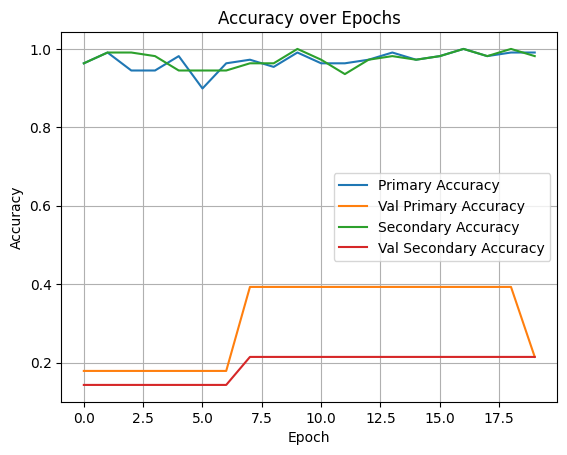

In [27]:
import matplotlib.pyplot as plt

# fit 결과 저장했을 경우
# history = model.fit(...)

plt.plot(history.history['primary_output_accuracy'], label='Primary Accuracy')
plt.plot(history.history['val_primary_output_accuracy'], label='Val Primary Accuracy')
plt.plot(history.history['secondary_output_accuracy'], label='Secondary Accuracy')
plt.plot(history.history['val_secondary_output_accuracy'], label='Val Secondary Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [31]:
# 성능 평가
loss, loss_primary, loss_secondary, acc_primary, acc_secondary = model.evaluate(
    X_val,
    {'primary_output': y_val_primary, 'secondary_output': y_val_secondary}
)

print(f"Primary Accuracy: {acc_primary:.4f}")
print(f"Secondary Accuracy: {acc_secondary:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 8.6630 - primary_output_accuracy: 0.2143 - primary_output_loss: 2.9078 - secondary_output_accuracy: 0.2143 - secondary_output_loss: 5.7552
Primary Accuracy: 0.2143
Secondary Accuracy: 0.2143


## 감정 결과 확인

In [33]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# 1. 저장된 모델 불러오기
model = load_model('emotion_classifier_model.h5')

# 2. 클래스 라벨 정의
primary_classes = ['긍정', '부정', '약올리기', '중립']
secondary_classes = [
    '긍정_웃김', '긍정_장난스러움',
    '부정_세모입', '부정_열받음',
    '중립_기본', '중립_몰입',
    '약올리기_단독'
]

# 3. 이미지 불러오기 및 전처리
img_path = './test.png'  # 테스트할 이미지 경로
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # 배치 차원 추가

# 4. 예측
pred_primary, pred_secondary = model.predict(img)

# 5. 결과 해석
primary_label = primary_classes[np.argmax(pred_primary)]
secondary_label = secondary_classes[np.argmax(pred_secondary)]

# 6. 출력
print(f'예측 결과')
print(f'1차 감정: {primary_label}')
print(f'2차 감정: {secondary_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
예측 결과
1차 감정: 부정
2차 감정: 긍정_장난스러움
